In [1]:
import xarray as xr
import numpy as np

import os
import torch
import math
import tqdm
import random

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
temperature_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalTemperature/Land_and_Ocean_LatLong1.nc"
co2_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalGhgEmissions/CO2_1deg_month_1850-2013.nc"
ssp_path = "/Users/jinho/Desktop/climatePrediction/data/raw/globalGhgEmissions/CO2_SSP119_2015_2150.nc"

In [3]:
temperature_ds = xr.open_dataset(temperature_path)
co2_ds = xr.open_dataset(co2_path)

temperature_ds['time'] = temperature_ds['time'].assign_coords(time=np.arange(len(temperature_ds.time)))
co2_ds['Times'] = co2_ds['Times'].assign_coords(Times=np.arange(len(co2_ds.Times)))


ssp_ds = xr.open_dataset(ssp_path)
ssp_ds['time'] = ssp_ds['time'].assign_coords(time=np.arange(len(ssp_ds.time)))

In [4]:
# Extract temperature data
temperature_data = temperature_ds['temperature']
temperature_mean = temperature_data.mean()
temperature_std = temperature_data.std()
normalized_temperature = (temperature_data - temperature_mean) / temperature_std

climatology = temperature_ds['climatology']
land_mask = temperature_ds['land_mask']

data_dict = {
    'temperature': normalized_temperature,
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': co2_ds['value'],
    'time_length': 1968, # 1850-2013
}

test_data_dict = {
    'temperature': normalized_temperature[1980:1980+109],
    'climatology': climatology,
    'land_mask': land_mask,
    'co2': ssp_ds['CO2'],
    'time_length': 108,  # 2015-2023
}

In [5]:
class TrainData(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 9000  # Randomly chosen number

    def __getitem__(self, index):
        while True:
            # Randomly select a location
            lat = random.choice(self.latitudes)
            lon = random.choice(self.longitudes)
            start_time = random.randint(0, self.time_steps - 1)  # Randomly select a starting time step

            temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
            co2_sequence = self.data_dict['co2'].sel(LatDim=int(89.5 - lat), LonDim=int(179.5 - lon)).values
            
            land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
            lat_norm = lat / 90

            months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
            cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
            sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

            x_temp = temperature_sequence[start_time:start_time + self.seq_length]
            x_co2 = co2_sequence[start_time:start_time + self.seq_length]
            x_combined = list(zip(x_temp, x_co2))
            
            y = temperature_sequence[start_time + self.seq_length]

            if not np.isnan(x_temp).any() and not np.isnan(y):
                # Prepare input features for each timestep
                x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
                x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
                
                return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [6]:
class TestData(Dataset):
    def __init__(self, data_dict, seq_length):
        """
        Initializes the dataset with a dictionary of data variables.
        :param data_dict: Dictionary of data variables (e.g., {'temperature': ..., 'land_mask': ...}).
        :param seq_length: Number of historical steps used as input to the model.
        """
        self.data_dict = data_dict
        self.seq_length = seq_length
        # Assumes all data variables share the same latitude and longitude coordinates
        self.latitudes = data_dict['land_mask']['latitude'].values
        self.longitudes = data_dict['land_mask']['longitude'].values
        
        self.time_steps = data_dict['time_length'] - seq_length + 1

    def __len__(self):
        return 1000  # Randomly chosen number

    def __getitem__(self, index):
        while True:
            # Randomly select a location
            lat = random.choice(self.latitudes)
            lon = random.choice(self.longitudes)
            start_time = random.randint(0, self.time_steps - 1)  # Randomly select a starting time step

            temperature_sequence = self.data_dict['temperature'].sel(latitude=lat, longitude=lon, method="nearest").values
            co2_sequence = self.data_dict['co2'].sel(latitude=lat, longitude=lon, method="nearest").values
            
            land_mask = self.data_dict['land_mask'].sel(latitude=lat, longitude=lon, method="nearest").values.item()  # Get scalar value
            lat_norm = lat / 90

            months = [(start_time + i) % 12 for i in range(self.seq_length + 1)]  # Calculate month for each timestep
            cos_months = [np.cos(2 * np.pi * month / 12) for month in months]
            sin_months = [np.sin(2 * np.pi * month / 12) for month in months]

            x_temp = temperature_sequence[start_time:start_time + self.seq_length]
            x_co2 = co2_sequence[start_time:start_time + self.seq_length]
            x_combined = list(zip(x_temp, x_co2))
            
            y = temperature_sequence[start_time + self.seq_length]

            if not np.isnan(x_temp).any() and not np.isnan(y):
                # Prepare input features for each timestep
                x_features = [np.append(np.array([temp[0], temp[1]]), [land_mask, lat_norm, cos_months[i], sin_months[i]]) for i, temp in enumerate(x_combined)]
                x_concat = np.stack(x_features)  # Stack to form a 2D array where each row is a timestep
                
                return torch.tensor(x_concat, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [7]:
# Data parameters
seq_length = 24
batch_size = 16

# Create the Dataset
train_dataset = TrainData(data_dict, seq_length)
test_dataset = TestData(test_data_dict, seq_length)

# Split data into training and testing
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# print(train_size, val_size, len(test_dataset))
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Example: Iterate over train_loader
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break  # remove this break to process all batches

# for inputs, labels in val_loader:
#     print(inputs.shape, labels.shape)
#     break  # remove this break to process all batches

for inputs, labels in test_loader:
    print(inputs.shape, labels.shape)
    break  # remove this break to process all batches

torch.Size([16, 24, 6]) torch.Size([16])
torch.Size([16, 24, 6]) torch.Size([16])


In [8]:
# Device configuration - uses GPU if available
# Check for device availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: mps


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass through RNN layer
        out, _ = self.rnn(x, h0)
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [11]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0)
        
        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [12]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        
        # Forward pass through the first fully connected layer
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        
        # Forward pass through the second fully connected layer
        x = self.fc4(x)
        return x

In [13]:
class AttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(AttentionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        
        # Compute attention weights
        energy = torch.tanh(self.attn(out))
        attention = torch.softmax(torch.matmul(energy, self.v), dim=1)
        
        attention = attention.unsqueeze(-1)
        
        # Apply attention weights to LSTM outputs
        context = attention * out
        context = torch.sum(context, dim=1)
        
        # Pass the context to the fully connected layer
        out = self.fc(context)
        return out

In [14]:
# Initialize the LSTM model
input_size = 6  # input feature dimension
hidden_size = 100  # number of features in hidden state
num_layers = 4  # number of stacked LSTM layers
output_size = 1  # output feature dimension (predicting one value)

lstm = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
rnn = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
gru = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
mlp = MLPModel(input_size * seq_length, hidden_size, output_size).to(device)
attn = AttentionModel(input_size, hidden_size, num_layers, output_size).to(device)

# Parameters
num_epochs = 20

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume lstm initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()
lstm.to(device)  # Ensure the lstm is on the correct device

for epoch in range(num_epochs):
    lstm.train()  # Make sure the lstm is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = lstm(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    lstm.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = lstm(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the lstm is back to train mode after validation
lstm.train()


Epoch 0: Train Loss 0.49216803908348083, Val Loss 1.0878978040483263
Epoch 1: Train Loss 0.22858688235282898, Val Loss 1.3109740257736235
Epoch 2: Train Loss 0.07788389921188354, Val Loss 1.4576733566465832
Epoch 3: Train Loss 0.5122246742248535, Val Loss 1.1855929314144074
Epoch 4: Train Loss 0.6248738765716553, Val Loss 1.2299873467002596
Epoch 5: Train Loss 2.4153854846954346, Val Loss 1.3476771326765182
Epoch 6: Train Loss 0.8252961039543152, Val Loss 1.094575163154375
Epoch 7: Train Loss 0.6432688236236572, Val Loss 1.571953208673568
Epoch 8: Train Loss 0.44678372144699097, Val Loss 1.5949555715871235
Epoch 9: Train Loss 0.9272568225860596, Val Loss 1.0641381099583611
Epoch 10: Train Loss 1.7343143224716187, Val Loss 1.376648699007337
Epoch 11: Train Loss 0.2447904348373413, Val Loss 1.1545536525192714
Epoch 12: Train Loss 0.5352319478988647, Val Loss 1.273716967020716
Epoch 13: Train Loss 0.995556652545929, Val Loss 1.1373752246773432
Epoch 14: Train Loss 0.22464412450790405, Val

LSTMModel(
  (lstm): LSTM(6, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Test Loss 1.1088134409889343
Actual mean: 0.6766565202416532, Predicted mean: 0.5297884741351009


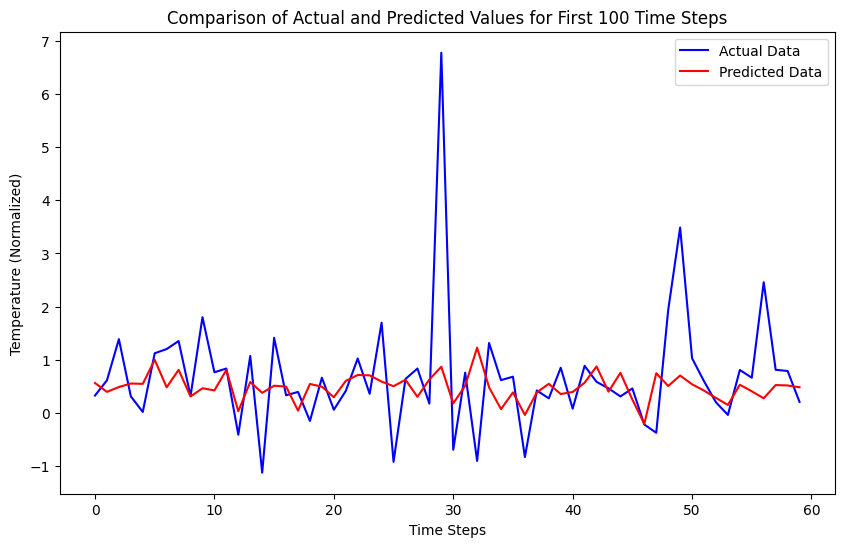

In [16]:
lstm.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = lstm(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume rnn initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()
rnn.to(device)  # Ensure the rnn is on the correct device

for epoch in range(num_epochs):
    rnn.train()  # Make sure the rnn is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = rnn(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    rnn.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = rnn(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')
    

# Optionally, you may want to ensure the rnn is back to train mode after validation
rnn.train()


Epoch 0: Train Loss 0.2936219573020935, Val Loss 2.0824240185911695
Epoch 1: Train Loss 0.15946853160858154, Val Loss 1.8352284909240784
Epoch 2: Train Loss 0.9287439584732056, Val Loss 2.443688408722953
Epoch 3: Train Loss 0.23047809302806854, Val Loss 1.930374646943713
Epoch 4: Train Loss 0.4688040018081665, Val Loss 2.0452394107031444
Epoch 5: Train Loss 0.3465721309185028, Val Loss 1.7236346048968179
Epoch 6: Train Loss 0.3572937846183777, Val Loss 2.123474085141742
Epoch 7: Train Loss 0.5620701313018799, Val Loss 1.899925201185166
Epoch 8: Train Loss 0.5564780831336975, Val Loss 1.689916670795471
Epoch 9: Train Loss 0.3025919497013092, Val Loss 2.069338355745588
Epoch 10: Train Loss 0.620082437992096, Val Loss 1.8308310295854295
Epoch 11: Train Loss 0.4196407198905945, Val Loss 2.2417055217046586
Epoch 12: Train Loss 0.26561254262924194, Val Loss 2.1164902718294236
Epoch 13: Train Loss 0.15362727642059326, Val Loss 1.9495551496271104
Epoch 14: Train Loss 0.6719270944595337, Val Lo

RNNModel(
  (rnn): RNN(6, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Test Loss 2.3757508917460366
Actual mean: 0.7910165579025633, Predicted mean: -0.19925156235694885


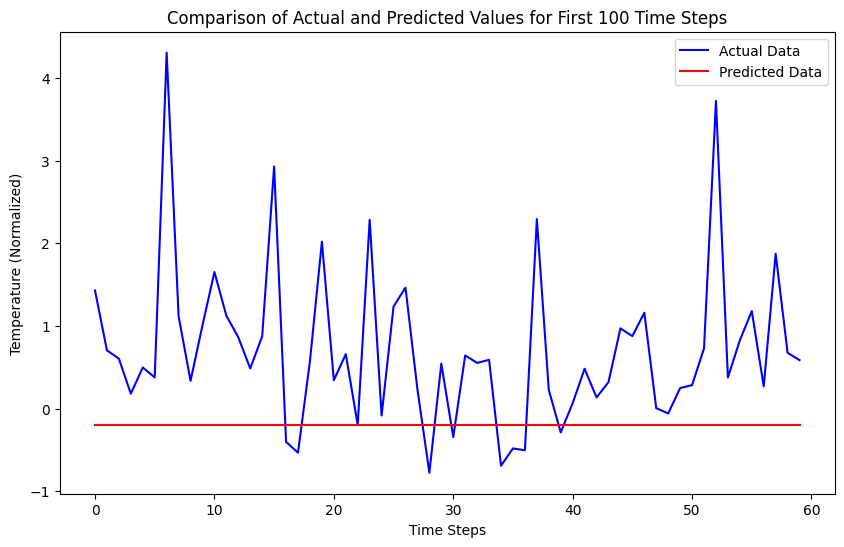

In [28]:
rnn.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = rnn(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume gru initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(gru.parameters(), lr=0.001)
criterion = nn.MSELoss()
gru.to(device)  # Ensure the gru is on the correct device

for epoch in range(num_epochs):
    gru.train()  # Make sure the gru is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = gru(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    gru.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = gru(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')
    

# Optionally, you may want to ensure the gru is back to train mode after validation
gru.train()


Epoch 0: Train Loss 0.870824933052063, Val Loss 2.2816982174676563
Epoch 1: Train Loss 0.3175843060016632, Val Loss 2.116123520192646
Epoch 2: Train Loss 1.5775978565216064, Val Loss 1.9051023385827504
Epoch 3: Train Loss 0.8474421501159668, Val Loss 2.0081700647161123
Epoch 4: Train Loss 0.16790242493152618, Val Loss 1.5883559154139624
Epoch 5: Train Loss 0.986152172088623, Val Loss 1.4537688905284518
Epoch 6: Train Loss 0.15496711432933807, Val Loss 1.3294387800352914
Epoch 7: Train Loss 3.146223783493042, Val Loss 1.606258542528228
Epoch 8: Train Loss 0.4185306131839752, Val Loss 1.4527797280322938
Epoch 9: Train Loss 0.3181239068508148, Val Loss 1.3658663994736142
Epoch 10: Train Loss 4.195204734802246, Val Loss 1.6687040683769045
Epoch 11: Train Loss 0.3451426029205322, Val Loss 1.4297974440786574
Epoch 12: Train Loss 0.23618078231811523, Val Loss 1.1972548223677135
Epoch 13: Train Loss 1.6578608751296997, Val Loss 1.4889125968255694
Epoch 14: Train Loss 0.04306718334555626, Val L

GRUModel(
  (gru): GRU(6, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Test Loss 1.5708024089062025
Actual mean: 0.7321564317864832, Predicted mean: 0.24969374877028166


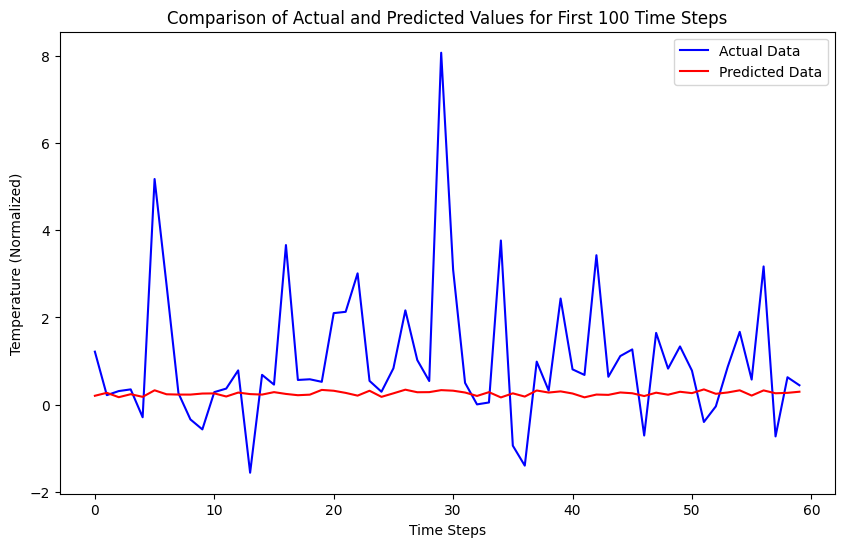

In [20]:
gru.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = gru(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume mlp initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()
mlp.to(device)  # Ensure the mlp is on the correct device

for epoch in range(num_epochs):
    mlp.train()  # Make sure the mlp is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = mlp(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    mlp.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = mlp(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the mlp is back to train mode after validation
mlp.train()


Epoch 0: Train Loss 3.499105453491211, Val Loss 1.4472040262014148
Epoch 1: Train Loss 0.12686479091644287, Val Loss 1.3149896966559547
Epoch 2: Train Loss 0.2040444165468216, Val Loss 1.430598761354174
Epoch 3: Train Loss 0.6342517137527466, Val Loss 1.6862035663354964
Epoch 4: Train Loss 0.50823974609375, Val Loss 1.10981427937273
Epoch 5: Train Loss 1.253856897354126, Val Loss 1.6019701650218359
Epoch 6: Train Loss 0.6796402335166931, Val Loss 1.5773420258173867
Epoch 7: Train Loss 1.1387214660644531, Val Loss 1.0514446511155082
Epoch 8: Train Loss 2.359381675720215, Val Loss 1.057560929703334
Epoch 9: Train Loss 1.0077388286590576, Val Loss 2.362913207402305
Epoch 10: Train Loss 0.09437635540962219, Val Loss 0.9802327210467959
Epoch 11: Train Loss 0.18739280104637146, Val Loss 1.398529206949567
Epoch 12: Train Loss 0.24921618402004242, Val Loss 1.0907656905196963
Epoch 13: Train Loss 0.15637391805648804, Val Loss 1.0314475676370045
Epoch 14: Train Loss 2.1447746753692627, Val Loss 

MLPModel(
  (fc1): Linear(in_features=144, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
)

Test Loss 1.3054037001870928
Actual mean: 0.7800173793698777, Predicted mean: 0.5006169477924705


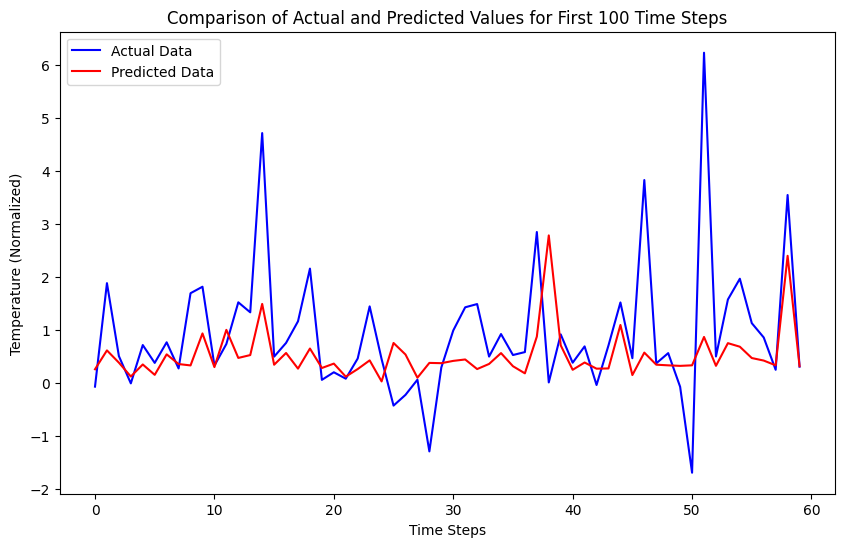

In [22]:
mlp.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = mlp(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assume attn initialization, data loaders, and device setting are defined above

optimizer = optim.Adam(attn.parameters(), lr=0.001)
criterion = nn.MSELoss()
attn.to(device)  # Ensure the attn is on the correct device

for epoch in range(num_epochs):
    attn.train()  # Make sure the attn is in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = attn(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to match the target's shape

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # Check validation loss
    attn.eval()
    total_val_loss = 0
    count = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            val_outputs = attn(xb)
            val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
            batch_loss = criterion(val_outputs, yb)
            total_val_loss += batch_loss.item()
            count += 1

    avg_val_loss = total_val_loss / count
    print(f'Epoch {epoch}: Train Loss {loss.item()}, Val Loss {avg_val_loss}')

# Optionally, you may want to ensure the attn is back to train mode after validation
attn.train()


Epoch 0: Train Loss 3.5940983295440674, Val Loss 2.3286323698740157
Epoch 1: Train Loss 0.6751468777656555, Val Loss 1.3347936040825314
Epoch 2: Train Loss 0.7301690578460693, Val Loss 1.401976045398485
Epoch 3: Train Loss 1.2419179677963257, Val Loss 1.3592521912521787
Epoch 4: Train Loss 1.195141077041626, Val Loss 1.4423975128503073
Epoch 5: Train Loss 0.5103286504745483, Val Loss 1.2502717479826913
Epoch 6: Train Loss 1.0507131814956665, Val Loss 1.5110199094291716
Epoch 7: Train Loss 0.990391194820404, Val Loss 1.258224881357617
Epoch 8: Train Loss 1.0465582609176636, Val Loss 1.5886465753354724
Epoch 9: Train Loss 0.7474771738052368, Val Loss 1.4174312369691
Epoch 10: Train Loss 3.082965850830078, Val Loss 1.5488029387262132
Epoch 11: Train Loss 0.5622240304946899, Val Loss 1.2945439328276922
Epoch 12: Train Loss 1.2713704109191895, Val Loss 1.0466887042635964
Epoch 13: Train Loss 0.29631611704826355, Val Loss 1.1179003578329842
Epoch 14: Train Loss 0.8873311877250671, Val Loss 1

AttentionModel(
  (lstm): LSTM(6, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (attn): Linear(in_features=100, out_features=100, bias=True)
)

Test Loss 1.045576699787662
Actual mean: 0.7642717437389656, Predicted mean: 0.7990558240115643


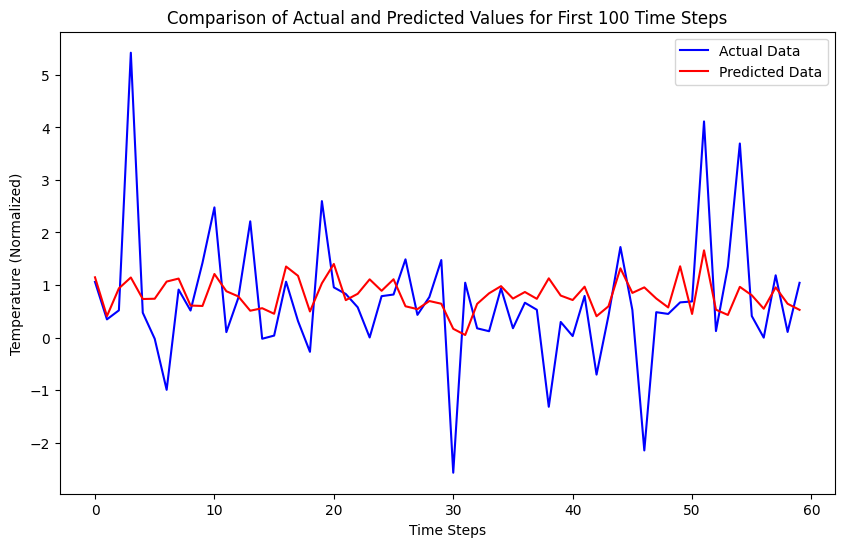

In [24]:
attn.eval()

total_val_loss = 0
count = 0
actual = []
predicted = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        val_outputs = attn(xb)
        val_outputs = val_outputs.squeeze()  # Adjust output shape if necessary
        batch_loss = criterion(val_outputs, yb)
        total_val_loss += batch_loss.item()
        count += 1
        
        actual.extend(yb.tolist())
        predicted.extend(val_outputs.squeeze().tolist())

avg_val_loss = total_val_loss / count
print(f'Test Loss {avg_val_loss}')
print(f'Actual mean: {np.mean(actual)}, Predicted mean: {np.mean(predicted)}')

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


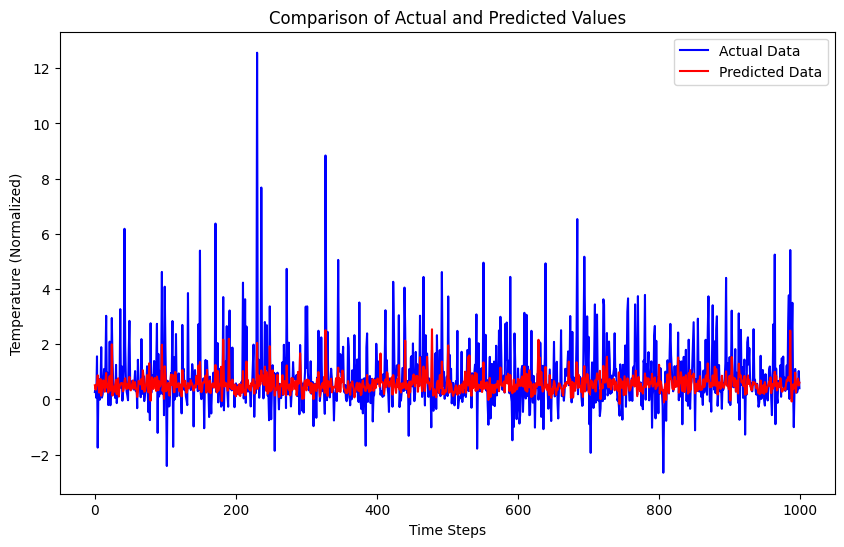

In [25]:
import matplotlib.pyplot as plt

# Assuming 'test_loader' is already defined and contains the test data
# Assuming 'model' is your trained model, loaded with trained weights and set to eval mode

model = lstm

model.eval()  # Ensure the model is in evaluation mode
actual = []
predicted = []

# Generate predictions and compare with actual values
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Store results
        actual.extend(labels.tolist())
        predicted.extend(outputs.squeeze().tolist())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


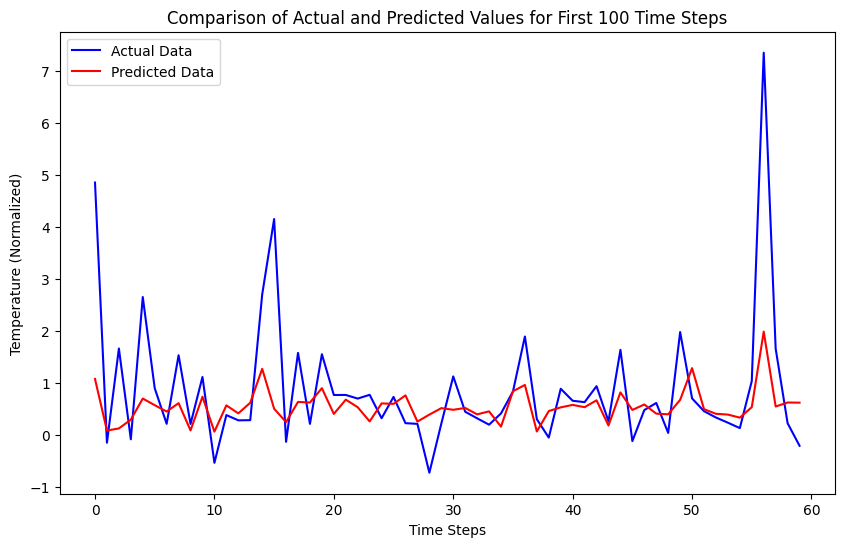

In [26]:
import matplotlib.pyplot as plt

# Assuming 'test_loader' is already defined and contains the test data
# Assuming 'model' is your trained model, loaded with trained weights and set to eval mode

model.eval()  # Ensure the model is in evaluation mode
actual = []
predicted = []

# Generate predictions and compare with actual values
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        
        # Store results
        actual.extend(labels.tolist())
        predicted.extend(outputs.squeeze().tolist())

# Limit the data points to the first 100 for visualization
actual = actual[200:260]
predicted = predicted[200:260]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual Data', color='blue')
plt.plot(predicted, label='Predicted Data', color='red')
plt.title('Comparison of Actual and Predicted Values for First 100 Time Steps')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()
